# Predicting Mackey-Glass timeseries

In [1]:
import brainpy as bp
import brainpy.math as bm
bm.set_platform('cpu')
bm.enable_x64()
bm.set_dfloat(bm.float64)

In [22]:
import numpy as np
import matplotlib.pyplot as plt

## Dataset

In [3]:
def plot_mackey_glass_series(ts, x_series, x_tau_series, num_sample):
  plt.figure(figsize=(13, 5))

  plt.subplot(121)
  plt.title(f"Timeserie - {num_sample} timesteps")
  plt.plot(ts[:num_sample], x_series[:num_sample], lw=2, color="lightgrey", zorder=0)
  plt.scatter(ts[:num_sample], x_series[:num_sample], c=ts[:num_sample], cmap="viridis", s=6)
  plt.xlabel("$t$")
  plt.ylabel("$P(t)$")

  ax = plt.subplot(122)
  ax.margins(0.05)
  plt.title(f"Phase diagram: $P(t) = f(P(t-\\tau))$")
  plt.plot(x_tau_series[: num_sample], x_series[: num_sample], lw=1, color="lightgrey", zorder=0)
  plt.scatter(x_tau_series[:num_sample], x_series[: num_sample], lw=0.5, c=ts[:num_sample], cmap="viridis", s=6)
  plt.xlabel("$P(t-\\tau)$")
  plt.ylabel("$P(t)$")
  cbar = plt.colorbar()
  # cbar.ax.set_ylabel('$t$', rotation=270)
  cbar.ax.set_ylabel('$t$')

  plt.tight_layout()
  plt.show()

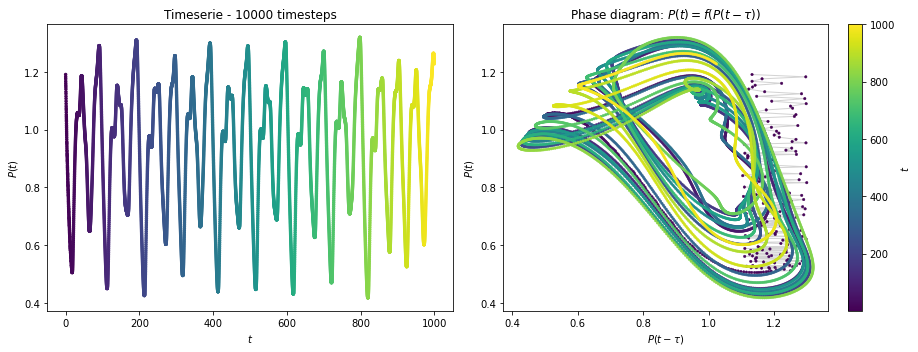

In [4]:
dt = 0.1

mg_data = bp.datasets.mackey_glass_series(25000, dt=dt, tau=17, beta=0.2, gamma=0.1, n=10, inits=1.2, seed=123)

plot_mackey_glass_series(mg_data['ts'], mg_data['x'], mg_data['x_tau'], num_sample=int(1000 / dt))

In [23]:
forecast = int(10 / dt)  # predict 10 s ahead
train_length = int(20000 / dt)
sample_rate = int(1 / dt)

X_train = mg_data['x'][:train_length:sample_rate]
Y_train = mg_data['x'][forecast: train_length + forecast: sample_rate]
X_test = mg_data['x'][train_length: -forecast: sample_rate]
Y_test = mg_data['x'][train_length + forecast::sample_rate]

X_train = np.expand_dims(X_train, 0)
Y_train = np.expand_dims(Y_train, 0)
X_test = np.expand_dims(X_test, 0)
Y_test = np.expand_dims(Y_test, 0)

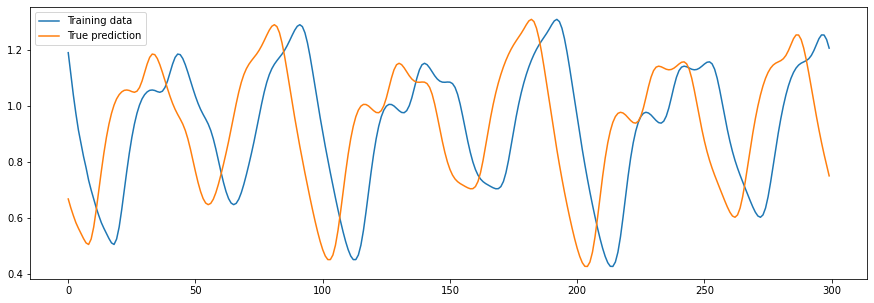

In [6]:
sample = 300
fig = plt.figure(figsize=(15, 5))
plt.plot(X_train[:sample], label="Training data")
plt.plot(Y_train[:sample], label="True prediction")
plt.legend()
plt.show()

## Model

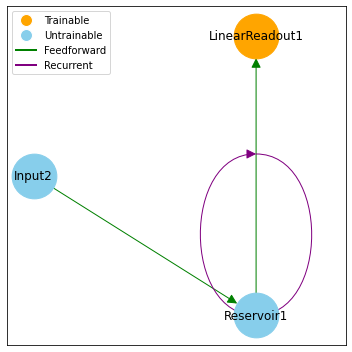

In [16]:
model = (
    bp.nn.Input(1)
    >> bp.nn.Reservoir(100, rec_initializer=bp.init.Normal(1. / (0.1 * 100) ** 0.5))
    >> bp.nn.LinearReadout(1)
)
model.plot_node_graph(fig_size=(5, 5))
model.initialize(1)

In [17]:
runner = bp.nn.RNNRunner(model, )

In [24]:
runner.predict(bm.asarray(X_train))

  0%|          | 0/20000 [00:00<?, ?it/s]

JaxArray([[[0.03929836],
           [0.04267574],
           [0.04461838],
           ...,
           [0.02899959],
           [0.03146453],
           [0.03396582]]], dtype=float64)

## Training

In [25]:
trainer = bp.nn.RidgeTrainer(model, beta=1e-6)

In [26]:
trainer.fit([bm.asarray(X_train),
             bm.asarray(Y_train)])

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

## Prediction

  0%|          | 0/20000 [00:00<?, ?it/s]

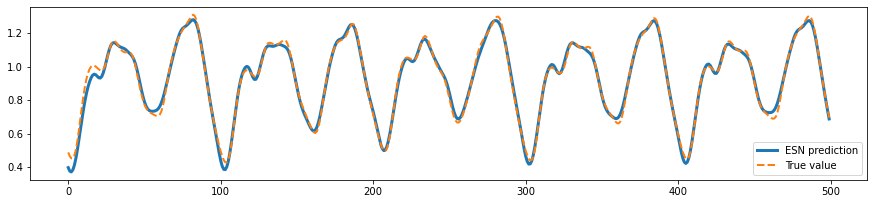

In [27]:
ys_predict = trainer.predict(bm.asarray(X_train), reset=True)

start, end = 100, 600
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(bm.arange(end - start).numpy(),
         ys_predict.numpy()[0, start:end, 0],
         lw=3,
         label="ESN prediction")
plt.plot(bm.arange(end - start).numpy(),
         Y_train[0, start:end, 0],
         linestyle="--",
         lw=2,
         label="True value")
plt.legend()
plt.show()

  0%|          | 0/4990 [00:00<?, ?it/s]

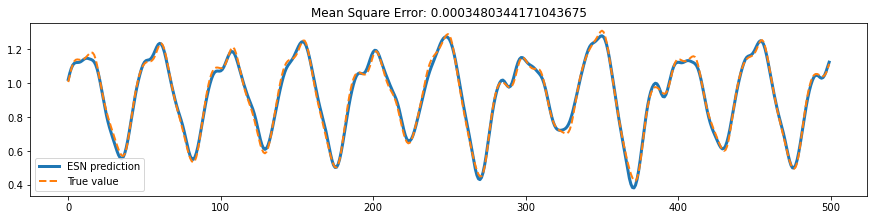

In [28]:
ys_predict = trainer.predict(bm.asarray(X_test), reset=True)

start, end = 100, 600
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(bm.arange(end - start).numpy(),
         ys_predict.numpy()[0, start:end, 0],
         lw=3,
         label="ESN prediction")
plt.plot(bm.arange(end - start).numpy(),
         Y_test[0, start:end, 0],
         linestyle="--",
         lw=2,
         label="True value")
plt.title(f'Mean Square Error: {bp.losses.mean_squared_error(ys_predict.numpy(), Y_test)}')
plt.legend()
plt.show()